------
**You cannot save any changes you make to this file, so please make sure to save it on your Google Colab drive or download it as a .ipynb file.**

------



Practical 1: Sentiment Detection in Movie Reviews
========================================



This practical concerns detecting sentiment in movie reviews. This is a typical NLP classification task.
In [this file](https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json) (80MB) you will find 1000 positive and 1000 negative **movie reviews**.
Each review is a **document** and consists of one or more sentences.

To prepare yourself for this practical, you should
have a look at a few of these texts to understand the difficulties of
the task: how might one go about classifying the texts? You will write
code that decides whether a movie review conveys positive or
negative sentiment.

Please make sure you have read the following paper:

>   Bo Pang, Lillian Lee, and Shivakumar Vaithyanathan
(2002).
[Thumbs up? Sentiment Classification using Machine Learning
Techniques](https://dl.acm.org/citation.cfm?id=1118704). EMNLP.

Bo Pang et al. introduced the movie review sentiment
classification task, and the above paper was one of the first papers on
the topic. The first version of your sentiment classifier will do
something similar to Pang et al.'s system. If you have questions about it,
you should resolve you doubts as soon as possible with your TA.


**Advice**

Please read through the entire practical and familiarise
yourself with all requirements before you start coding or otherwise
solving the tasks. Writing clean and concise code can make the difference
between solving the assignment in a matter of hours, and taking days to
run all experiments.


**Implementation**

While we inserted code cells to indicate where you should implement your own code, please feel free to add/remove code blocks where you see fit (but make sure that the general structure of the assignment is preserved). Also, please keep in mind that it is always good practice to structure your code properly, e.g., by implementing separate classes and functions that can be reused. **Make sure you run all your code before submitting the notebook, and do not leave unnecessary print statements / cells in your notebook that are not intended for the grader.**

## Environment

All code should be written in **Python 3**.
This is the default in Google Colab.

In [1]:
!python --version

Python 3.10.12


If you want to run code on your own computer, then download this notebook through `File -> Download .ipynb`.
The easiest way to
install Python is through downloading
[Anaconda](https://www.anaconda.com/download).
After installation, you can start the notebook by typing `jupyter notebook filename.ipynb`.
You can also use an IDE
such as [PyCharm](https://www.jetbrains.com/pycharm/download/) to make
coding and debugging easier. It is good practice to create a [virtual
environment](https://docs.python.org/3/tutorial/venv.html) for this
project, so that any Python packages don’t interfere with other
projects.


**Learning Python 3**

If you are new to Python 3, you may want to check out a few of these resources:
- https://learnxinyminutes.com/docs/python3/
- https://www.learnpython.org/
- https://docs.python.org/3/tutorial/

In [2]:
import math
import os
import sys
from subprocess import call
from nltk import FreqDist
from nltk.util import ngrams
from nltk.stem.porter import PorterStemmer
import sklearn as sk
from google.colab import drive
import pickle
import json
from collections import Counter, defaultdict
import requests
import matplotlib.pyplot as plt
import numpy as np
from nltk.stem import *
from nltk.stem.porter import *
from nltk import ngrams

## Loading the data

**Download the sentiment lexicon and the movie reviews dataset.**

In [3]:
# download sentiment lexicon
!wget https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon
# download review data
!wget https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json

--2024-11-13 08:51:20--  https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 662577 (647K) [text/plain]
Saving to: ‘sent_lexicon’

sent_lexicon        100%[===================>] 647.05K  --.-KB/s    in 0.04s   

2024-11-13 08:51:20 (17.7 MB/s) - ‘sent_lexicon’ saved [662577/662577]

--2024-11-13 08:51:20--  https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.

**Load the movie reviews.**

Each word in a review comes with its part-of-speech tag. For documentation on POS-tags, see https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf.


In [4]:
# file structure:
# [
#  {"cv": integer, "sentiment": str, "content": list}
#  {"cv": integer, "sentiment": str, "content": list}
#   ..
# ]
# where `content` is a list of sentences,
# with a sentence being a list of (token, pos_tag) pairs.


with open("reviews.json", mode="r", encoding="utf-8") as f:
  reviews = json.load(f)

print("Total number of reviews:", len(reviews), '\n')

def print_sentence_with_pos(s):
  print(" ".join("%s/%s" % (token, pos_tag) for token, pos_tag in s))

for i, r in enumerate(reviews):
  print(r["cv"], r["sentiment"], len(r["content"]))  # cv, sentiment, num sents
  print_sentence_with_pos(r["content"][0])
  if i == 4:
    break

pos_tags = set()
c = Counter()
for review in reviews:
  for sentence in review["content"]:
    for token, pos_tag in sentence:
      c[token.lower()] += 1
      pos_tags.add(pos_tag)
print(pos_tags)

print("\nNumber of word types:", len(c))
print("Number of word tokens:", sum(c.values()))

print("\nMost common tokens:")
for token, count in c.most_common(20):
  print("%10s : %8d" % (token, count))


Total number of reviews: 2000 

0 NEG 29
Two/CD teen/JJ couples/NNS go/VBP to/TO a/DT church/NN party/NN ,/, drink/NN and/CC then/RB drive/NN ./.
1 NEG 11
Damn/JJ that/IN Y2K/CD bug/NN ./.
2 NEG 24
It/PRP is/VBZ movies/NNS like/IN these/DT that/WDT make/VBP a/DT jaded/JJ movie/NN viewer/NN thankful/JJ for/IN the/DT invention/NN of/IN the/DT Timex/NNP IndiGlo/NNP watch/NN ./.
3 NEG 19
QUEST/NN FOR/IN CAMELOT/NNP ``/`` Quest/NNP for/IN Camelot/NNP ''/'' is/VBZ Warner/NNP Bros./NNP '/POS first/JJ feature-length/JJ ,/, fully-animated/JJ attempt/NN to/TO steal/VB clout/NN from/IN Disney/NNP 's/POS cartoon/NN empire/NN ,/, but/CC the/DT mouse/NN has/VBZ no/DT reason/NN to/TO be/VB worried/VBN ./.
4 NEG 38
Synopsis/NNPS :/: A/DT mentally/RB unstable/JJ man/NN undergoing/VBG psychotherapy/NN saves/VBZ a/DT boy/NN from/IN a/DT potentially/RB fatal/JJ accident/NN and/CC then/RB falls/VBZ in/IN love/NN with/IN the/DT boy/NN 's/POS mother/NN ,/, a/DT fledgling/NN restauranteur/NN ./.
{'-RRB-', 'PR

#(1) Lexicon-based approach (3.5pts)



A traditional approach to classify documents according to their sentiment is the lexicon-based approach. To implement this approach, you need a **sentiment lexicon**, i.e., a list of words annotated with a sentiment label (e.g., positive and negative, or a score from 0 to 5).

In this practical, you will use the sentiment
lexicon released by Wilson et al. (2005).

> Theresa Wilson, Janyce Wiebe, and Paul Hoffmann
(2005). [Recognizing Contextual Polarity in Phrase-Level Sentiment
Analysis](http://www.aclweb.org/anthology/H/H05/H05-1044.pdf). HLT-EMNLP.

Pay attention to all the information available in the sentiment lexicon. The field *word1* contains the lemma, *priorpolarity* contains the sentiment label (positive, negative, both, or neutral), *type* gives you the magnitude of the word's sentiment (strong or weak), and *pos1* gives you the part-of-speech tag of the lemma. Some lemmas can have multiple part-of-speech tags and thus multiple entries in the lexicon. The path of the lexicon file is `"sent_lexicon"`.


In [5]:
with open("sent_lexicon", mode="r", encoding="utf-8") as f:
  line_cnt = 0
  for line in f:
    print(line.strip())
    line_cnt += 1
    if line_cnt > 4:
      break

type=weaksubj len=1 word1=abandoned pos1=adj stemmed1=n priorpolarity=negative
type=weaksubj len=1 word1=abandonment pos1=noun stemmed1=n priorpolarity=negative
type=weaksubj len=1 word1=abandon pos1=verb stemmed1=y priorpolarity=negative
type=strongsubj len=1 word1=abase pos1=verb stemmed1=y priorpolarity=negative
type=strongsubj len=1 word1=abasement pos1=anypos stemmed1=y priorpolarity=negative


Lexica such as this can be used to solve
the classification task without using Machine Learning. For example, one might look up every word $w_1 ... w_n$ in a document, and compute a **binary score**
$S_{binary}$ by counting how many words have a positive or a
negative label in the sentiment lexicon $SLex$.

$$S_{binary}(w_1 w_2 ... w_n) = \sum_{i = 1}^{n}\text{sign}(SLex\big[w_i\big])$$

where $\text{sign}(SLex\big[w_i\big])$ refers to the polarity of $w_i$.

**Threshold.** On average, there are more positive than negative words per review (~7.13 more positive than negative per review) to take this bias into account you should use a threshold of **8** (roughly the bias itself) to make it harder to classify as positive.

$$
\text{classify}(S_{binary}(w_1 w_2 ... w_n)) = \bigg\{\begin{array}{ll}
        \text{positive} & \text{if } S_{binary}(w_1w_2...w_n) > threshold\\
        \text{negative} & \text{otherwise}
        \end{array}
$$


#### (Q1.1) Implement this approach and report its classification accuracy. (1 pt)

In [6]:
# YOUR CODE HERE
sent_dict_sign, sent_dict_weight = {}, {}
polarity = {'negative': -1, 'positive': 1, 'both': 0, 'neutral': 0}

with open("sent_lexicon", mode="r", encoding="utf-8") as f:
  for line in f:
    items = dict([elem.split('=') for elem in line.strip().split()])
    sent_dict_sign[items['word1']] = polarity[items['priorpolarity']]
    sent_dict_weight[items['word1']] = 1 if (items['type'] == 'weaksubj') else 2

score_bin = []
for review in reviews:
  s_bin = 0
  for sentence in review["content"]:
    for token, _ in sentence:
      s_bin += sent_dict_sign.get(token.lower(), 0)
  score_bin.append(s_bin)

In [7]:
# token_results should be a list of binary indicators; for example [1, 0, 1, ...]
# where 1 indicates a correct classification and 0 an incorrect classification.
from sklearn.metrics import accuracy_score

true_labels = [int(review['sentiment'] == 'POS') for review in reviews]

token_results = [int(elem >= 8) for elem in score_bin]
token_accuracy = accuracy_score(true_labels, token_results)
print(f"Accuracy: {token_accuracy}")

Accuracy: 0.679


As the sentiment lexicon also has information about the **magnitude** of
sentiment (e.g., *“excellent"* has the same sentiment _polarity_ as *“good"* but it has a higher magnitude), we can take a more fine-grained approach by adding up all
sentiment scores, and deciding the polarity of the movie review using
the sign of the weighted score $S_{weighted}$.

$$S_{weighted}(w_1w_2...w_n) = \sum_{i = 1}^{n}SLex\big[w_i\big]$$


Make sure you define an appropriate threshold for this approach.

#### (Q1.2) Now incorporate magnitude information and report the classification accuracy. Don't forget to use the threshold. (1pt)

In [8]:
# YOUR CODE HERE
score_mag = []
for review in reviews:
  s_bin = 0
  for sentence in review["content"]:
    for token, _ in sentence:
      s_bin += sent_dict_weight.get(token.lower(), 0) * sent_dict_sign.get(token.lower(), 0)
  score_mag.append(s_bin)

In [9]:
av_diff = 7.13 * 1.3

magnitude_results = [int(elem >= av_diff) for elem in score_mag] # threshold with assumption that out of these 7.12 words half are strong sentimented
magnitude_accuracy = accuracy_score(true_labels, magnitude_results)
print(f"Accuracy: {magnitude_accuracy}")

Accuracy: 0.687


#### (Q.1.3) Make a barplot of the two results (0.5pt)

<BarContainer object of 2 artists>

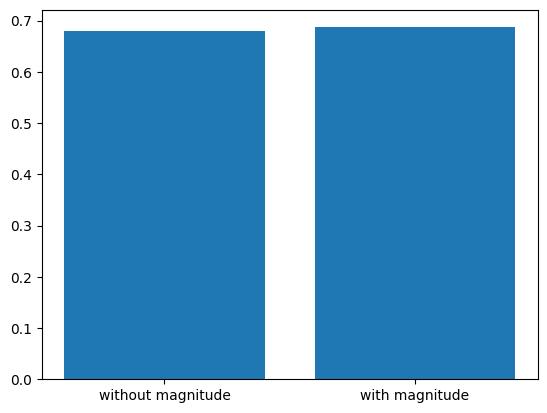

In [10]:
# YOUR CODE HERE
plt.bar(['without magnitude', 'with magnitude'], [token_accuracy, magnitude_accuracy])

#### (Q1.4) A better threshold (1pt)
Above we have defined a threshold to account for an inherent bias in the dataset: there are more positive than negative words per review.
However, that threshold does not take into account *document length*. Explain why this is a problem and implement an alternative way to compute the threshold.

*Write your answer here.*

In [11]:
# YOUR CODE HERE
average_length = sum([len(review['content']) for review in reviews]) / len(reviews)
# EXPLANATION:
# on average there are 8 more positive words, but for longer texts (and shorter
# similarly), we expect proportionally more positive words. makes sense to take
# length / average_length as the scaling factor

token_results = [int(score >= 7.13 * (len(review['content']) / average_length)) for score, review in zip(score_bin, reviews)]
token_accuracy = accuracy_score(true_labels, token_results)
print(f"Accuracy token: {token_accuracy}")

Accuracy token: 0.672


In [12]:
av_diff = 7.13 * 1.3

magnitude_results = [int(elem >= (av_diff * (len(review['content']) / average_length))) for elem in score_mag] # threshold with assumption that out of these 8 words half are strong sentimented
magnitude_accuracy = accuracy_score(true_labels, magnitude_results)
print(f"Accuracy: {magnitude_accuracy}")

Accuracy: 0.6895


# (2) Naive Bayes (9.5pts)


Your second task is to program a simple Machine Learning approach that operates
on a simple Bag-of-Words (BoW) representation of the text data, as
described by Pang et al. (2002). In this approach, the only features we
will consider are the words in the text themselves, without bringing in
external sources of information. The BoW model is a popular way of
representing texts as vectors, making it
easy to apply classical Machine Learning algorithms on NLP tasks.
However, the BoW representation is also very crude, since it discards
all information related to word order and grammatical structure in the
original text—as the name suggests.

## Writing your own classifier (4pts)

Write your own code to implement the Naive Bayes (NB) classifier. As
a reminder, the Naive Bayes classifier works according to the following
equation:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} P(c|\bar{f}) = \operatorname*{arg\,max}_{c \in C} P(c)\prod^n_{i=1} P(f_i|c)$$
where $C = \{ \text{POS}, \text{NEG} \}$ is the set of possible classes,
$\hat{c} \in C$ is the most probable class, and $\bar{f}$ is the feature
vector. Remember that we use the log of these probabilities when making
a prediction:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} \Big\{\log P(c) + \sum^n_{i=1} \log P(f_i|c)\Big\}$$

You can find more details about Naive Bayes in [Jurafsky &
Martin](https://web.stanford.edu/~jurafsky/slp3/). You can also look at
this helpful
[pseudo-code](https://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html).

*Note: this section and the next aim to put you in a position to replicate
    Pang et al.'s Naive Bayes results. However, your numerical results
    will differ from theirs, as they used different data.*

**You must write the Naive Bayes training and prediction code from
scratch.** You will not be given credit for using off-the-shelf Machine
Learning libraries.

The data contains the text of the reviews, where each document consists
of the sentences in the review, the sentiment of the review and an index
(cv) that you will later use for cross-validation. The
text has already been tokenised and POS-tagged for you. Your algorithm
should read in the text, **lowercase it**, store the words and their
frequencies in an appropriate data structure that allows for easy
computation of the probabilities used in the Naive Bayes algorithm, and
then make predictions for new instances.


In [13]:
class NaiveBayesClassifier:

  def __init__(self):

    self.class_count = Counter()
    self.word_given_class_count = defaultdict(lambda: Counter())
    self.total_words_per_class_count = Counter()
    self.vocabulary = set()
    self.word_presence_in_class = defaultdict(set)
    self.stemmer = PorterStemmer()
    self.UNK = "<UNK>"


  def data_process(self, content, stemm=False, ngrams_range=(1, 1)):
    # Consider sentence boundry
    if stemm:
      sentences = [[self.stemmer.stem(token.lower()) for token, pos_tag in sentence] for sentence in content]
    else:
      sentences = [[token.lower() for token, pos_tag in sentence] for sentence in content]

    ngrams_features = []

    for sentence in sentences:
      for n in range(ngrams_range[0], ngrams_range[1] + 1):
        ngrams_features += [' '.join(ngram) for ngram in ngrams(sentence, n)]

    return ngrams_features

  def train(self, reviews, stemm=False, ngrams_range=(1, 1), smooth=True):
    for review in reviews:
      self.class_count[review["sentiment"]] += 1

      words = self.data_process(review["content"], stemm, ngrams_range)

      self.vocabulary.update(words)

      for word in words:
        self.word_given_class_count[review["sentiment"]][word] += 1
        self.total_words_per_class_count[review["sentiment"]] += 1
        self.word_presence_in_class[word].add(review["sentiment"])

    self.vocabulary.add(self.UNK)
    for c in self.class_count:
      self.word_given_class_count[c][self.UNK] = 0

    if not smooth:
      words_to_remove = [word for word in self.vocabulary if len(self.word_presence_in_class[word]) < 2]
      for word in words_to_remove:
        self.vocabulary.remove(word)

    print(f"Size of the vocabulary:{len(self.vocabulary)}")

  def predict(self, content, stemm=False, ngrams_range=(1, 1), smooth=True):

    words = self.data_process(content, stemm, ngrams_range)

    class_probs = {}

    for c in self.class_count:
      log_P_c = math.log(self.class_count[c] / sum(self.class_count.values()))

      for word in words:
        # for smooth=False, UNK includes words in both case 1 & 2 (Q2.1)
        # for smooth=True, UNK includes words in case 1
        if word not in self.vocabulary:
          word = self.UNK

        if smooth:
          P_word_given_c = (self.word_given_class_count[c][word] + 1) / (self.total_words_per_class_count[c] + len(self.vocabulary))
        else:
          # if not smooth, skip the UNK
          if self.word_given_class_count[c][word] == 0:
            continue
          P_word_given_c = self.word_given_class_count[c][word] / self.total_words_per_class_count[c]

        log_P_word_given_c = math.log(P_word_given_c)
        log_P_c += log_P_word_given_c

      class_probs[c] = log_P_c

    # print(class_probs)

    return max(class_probs, key=class_probs.get)

#### (Q2.1) Unseen words (1pt)
The presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive Bayes classifier to equal $0$.
These can be words which are unseen in both positive and negative training reviews (case 1), but also words which are seen in reviews _of only one sentiment class_ in the training dataset (case 2). In both cases, **you should skip these words for both classes at test time**.  What would be the problem instead with skipping words only for one class in case 2?

>Keeping the word in only one class will add more negative terms in that class's sum log probability (0 < p < 1, log(p) < 0), which causes unfair comparison between the two classes and skews the classifier towards the opposite class when the same word appears in the test set.

#### (Q2.2) Train your classifier on (positive and negative) reviews with cv-value 000-899, and test it on the remaining (positive and negative) reviews cv900–cv999.  Report results using classification accuracy as your evaluation metric. Your  features are the word vocabulary. The value of a feature is the count of that feature (word) in the document. (2pts)


In [14]:
# YOUR CODE HERE
with open("reviews.json", mode="r", encoding="utf-8") as f:
  reviews = json.load(f)

train_reviews = [review for review in reviews if review["cv"] < 900]
test_reviews = [review for review in reviews if review["cv"] >= 900]

# print(train_reviews)
# print(test_reviews)

In [15]:
stemm = False
smooth = False
NBClassifier = NaiveBayesClassifier()
NBClassifier.train(train_reviews, stemm=stemm, smooth=smooth)

Size of the vocabulary:18799


In [16]:
predictions= []
for review in test_reviews:
  predictions.append(NBClassifier.predict(review["content"], stemm=stemm, smooth=smooth))

accuracy= sum([1 if predictions[i] == test_reviews[i]["sentiment"] else 0 for i in range(len(predictions))]) / len(predictions)
print(f"Accuracy (stemm={stemm}, smooth={smooth}) : {accuracy}")

Accuracy (stemm=False, smooth=False) : 0.825


#### (Q2.3) Would you consider accuracy to also be a good way to evaluate your classifier in a situation where 90% of your data instances are of positive movie reviews? (1pt)

Simulate this scenario by keeping the positive reviews
data unchanged, but only using negative reviews cv000–cv089 for
training, and cv900–cv909 for testing. Calculate the classification
accuracy, and explain what changed.

>In this case, accuracy is NOT a good way to evaluate the classifier because the data set is imbalanced. The classifer can simply predict "Positive" to gain higher accuracy instead of learning to distinguish between the positive and negative classes. The accuaracy in this scenario is 60% and it could be much lower if we have a test set that contains mostly negative reviews.

In [17]:
# YOUR CODE HERE
train_reviews_most_pos = [review for review in reviews if review["cv"] < 900 and review["sentiment"] == "POS"]
train_reviews_most_pos += [review for review in reviews if review["cv"] < 90 and review["sentiment"] == "NEG"]

# print(train_reviews_most_pos)

test_reviews_most_pos = [review for review in reviews if review["cv"] >= 900 and review["sentiment"] == "POS"]
test_reviews_most_pos += [review for review in reviews if review["cv"] >= 900 and review["cv"] < 910 and review["sentiment"] == "NEG"]

# print(test_reviews_most_pos)

In [18]:
stemm = False
smooth = False

NBClassifier = NaiveBayesClassifier()
NBClassifier.train(train_reviews_most_pos, stemm=stemm, smooth=smooth)

predictions = []
for review in test_reviews_most_pos:
  predictions.append(NBClassifier.predict(review["content"], stemm=stemm, smooth=smooth))

accuracy= sum([1 if predictions[i] == test_reviews_most_pos[i]["sentiment"] else 0 for i in range(len(predictions))]) / len(predictions)
print(f"Accuracy (stemm={stemm}, smooth={smooth}) : {accuracy}")

Size of the vocabulary:7351
Accuracy (stemm=False, smooth=False) : 0.6


## Smoothing (1pt)

As mentioned above, the presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive
Bayes classifier to be $0$, thus making that particular test instance
undecidable. The standard way to mitigate this effect (as well as to
give more clout to rare words) is to use smoothing, in which the
probability fraction
$$\frac{\text{count}(w_i, c)}{\sum\limits_{w\in V} \text{count}(w, c)}$$ for a word
$w_i$ becomes
$$\frac{\text{count}(w_i, c) + \text{smoothing}(w_i)}{\sum\limits_{w\in V} \text{count}(w, c) + \sum\limits_{w \in V} \text{smoothing}(w)}$$





#### (Q2.4) Implement Laplace feature smoothing (1pt)
Implement Laplace smoothing, i.e., smoothing with a constant value ($smoothing(w) = \kappa, \forall w \in V$), in your Naive
Bayes classifier’s code, and report the accuracy.
Use $\kappa = 1$.

In [19]:
# YOUR CODE HERE
stemm = False
smooth = True

NBClassifier = NaiveBayesClassifier()
NBClassifier.train(train_reviews, stemm=stemm, smooth=smooth)

predictions = []
for review in test_reviews:
  predictions.append(NBClassifier.predict(review["content"], stemm=stemm, smooth=smooth))

accuracy = sum([1 if predictions[i] == test_reviews[i]["sentiment"] else 0 for i in range(len(predictions))]) / len(predictions)
print(f"Accuracy (stemm={stemm}, smooth={smooth}) : {accuracy}")

Size of the vocabulary:45349
Accuracy (stemm=False, smooth=True) : 0.825


## Cross-Validation (1.5pts)

A serious danger in using Machine Learning on small datasets, with many
iterations of slightly different versions of the algorithms, is ending up with Type III errors, also called the “testing hypotheses
suggested by the data” errors. This type of error occurs when we make
repeated improvements to our classifiers by playing with features and
their processing, but we don’t get a fresh, never-before seen test
dataset every time. Thus, we risk developing a classifier that gets better
and better on our data, but only gets worse at generalizing to new, unseen data. In other words, we risk developping a classifier that overfits.

A simple method to guard against Type III errors is to use
Cross-Validation. In **N-fold Cross-Validation**, we divide the data into N
distinct chunks, or folds. Then, we repeat the experiment N times: each
time holding out one of the folds for testing, training our classifier
on the remaining N - 1 data folds, and reporting performance on the
held-out fold. We can use different strategies for dividing the data:

-   Consecutive splitting:
  - cv000–cv099 = Split 1
  - cv100–cv199 = Split 2
  - etc.
  
-   Round-robin splitting (mod 10):
  - cv000, cv010, cv020, … = Split 1
  - cv001, cv011, cv021, … = Split 2
  - etc.

-   Random sampling/splitting
  - Not used here (but you may choose to split this way in a non-educational situation)



#### (Q2.5) Write the code to implement 10-fold cross-validation using round-robin splitting for your Naive Bayes classifier from Q2.4 and compute the 10 accuracies. Report the final performance, which is the average of the performances per fold. If all splits perform equally well, this is a good sign. (1pt)

In [20]:
# YOUR CODE HERE
stemm = False
smooth = True

folds = {i: [] for i in range(10)}

for review in reviews:
  folds[review["cv"] % 10].append(review)

accuracies = []

for i in range(10):
  train_reviews = [review for review in reviews if review not in folds[i]]
  test_reviews = folds[i]

  NBClassifier = NaiveBayesClassifier()
  NBClassifier.train(train_reviews, stemm=stemm, smooth=smooth)

  predictions= []
  for review in test_reviews:
    predictions.append(NBClassifier.predict(review["content"], stemm=stemm, smooth=smooth))

  accuracy = sum([1 if predictions[i] == test_reviews[i]["sentiment"] else 0 for i in range(len(predictions))]) / len(predictions)
  accuracies.append(accuracy)

print(f"Accuracies each fold (stemm={stemm}, smooth={smooth}): {accuracies}")
avg_acc = sum(accuracies) / len(accuracies)
print(f"Average accuracy (stemm={stemm}, smooth={smooth}): {avg_acc}")

Size of the vocabulary:45330
Size of the vocabulary:45393
Size of the vocabulary:45439
Size of the vocabulary:45390
Size of the vocabulary:45649
Size of the vocabulary:45297
Size of the vocabulary:45366
Size of the vocabulary:45410
Size of the vocabulary:45558
Size of the vocabulary:45643
Accuracies each fold (stemm=False, smooth=True): [0.79, 0.835, 0.81, 0.83, 0.775, 0.85, 0.83, 0.78, 0.825, 0.845]
Average accuracy (stemm=False, smooth=True): 0.817


#### (Q2.6) Report the variance of the 10 accuracy scores. (0.5pt)

**Please report all future results using 10-fold cross-validation now
(unless told to use the held-out test set).** Note: you're not allowed to use a library for computing the variance.

In [21]:
# YOUR CODE HERE
variance = sum([(accuracies[i] - avg_acc) ** 2 for i in range(len(accuracies))]) / len(accuracies)
print(f"Variance: {variance}")

Variance: 0.0006509999999999987


## Features, overfitting, and the curse of dimensionality

In the Bag-of-Words model, ideally we would like each distinct word in
the text to be mapped to its own dimension in the output vector
representation. However, real world text is messy, and we need to decide
on what we consider to be a word. For example, is “`word`" different
from “`Word`", from “`word`”, or from “`words`"? Too strict a
definition, and the number of features explodes, while our algorithm
fails to learn anything generalisable. Too lax, and we risk destroying
our learning signal. In the following section, you will learn about
confronting the feature sparsity and the overfitting problems as they
occur in NLP classification tasks.

### Stemming (1.5pts)

To make your algorithm more robust, use stemming and hash different inflections of a word to the same feature in the BoW vector space. Please use the [Porter stemming
    algorithm](http://www.nltk.org/howto/stem.html) from NLTK.



In [ ]:
# YOUR CODE HERE
# Please refer to the class NaiveBayesClassifier, the def data_process is modified, adding another parameter: stemm.

#### (Q2.7): How does the performance of your classifier change when you use stemming on your training and test datasets? (1pt)
Use cross-validation to evaluate the classifier.


In [22]:
# YOUR ANSWER HERE
stemm = True
smooth = True

folds = {i: [] for i in range(10)}

for review in reviews:
  folds[review["cv"] % 10].append(review)

accuracies = []

for i in range(10):
  train_reviews = [review for review in reviews if review not in folds[i]]
  test_reviews = folds[i]

  NBClassifier = NaiveBayesClassifier()
  NBClassifier.train(train_reviews, stemm=stemm, smooth=smooth)

  predictions= []
  for review in test_reviews:
    predictions.append(NBClassifier.predict(review["content"], stemm=stemm, smooth=smooth))

  accuracy = sum([1 if predictions[i] == test_reviews[i]["sentiment"] else 0 for i in range(len(predictions))]) / len(predictions)
  accuracies.append(accuracy)

print(f"Accuracies each fold (stemm={stemm}, smooth={smooth}): {accuracies}")
avg_acc = sum(accuracies) / len(accuracies)
print(f"Average accuracy (stemm={stemm}, smooth={smooth}): {avg_acc}")

Size of the vocabulary:32372
Size of the vocabulary:32483
Size of the vocabulary:32546
Size of the vocabulary:32499
Size of the vocabulary:32700
Size of the vocabulary:32440
Size of the vocabulary:32441
Size of the vocabulary:32494
Size of the vocabulary:32577
Size of the vocabulary:32668
Accuracies each fold (stemm=True, smooth=True): [0.78, 0.84, 0.81, 0.85, 0.775, 0.835, 0.81, 0.775, 0.83, 0.84]
Average accuracy (stemm=True, smooth=True): 0.8145000000000001


#### (Q2.8) What happens to the number of features (i.e., the size of the vocabulary) when using stemming as opposed to (Q2.4)? (0.5pt)
Give actual numbers. You can use the held-out training set to determine these.

In [23]:
# YOUR CODE HERE
stemm = True
smooth = True

train_reviews = [review for review in reviews if review["cv"] < 900]
test_reviews = [review for review in reviews if review["cv"] >= 900]

NBClassifier = NaiveBayesClassifier()
NBClassifier.train(train_reviews, stemm=stemm, smooth=smooth)

predictions = []
for review in test_reviews:
  predictions.append(NBClassifier.predict(review["content"], stemm=stemm, smooth=smooth))

accuracy = sum([1 if predictions[i] == test_reviews[i]["sentiment"] else 0 for i in range(len(predictions))]) / len(predictions)
print(f"Accuracy (stemm={stemm}, smooth={smooth}): {accuracy}")

Size of the vocabulary:32405
Accuracy (stemm=True, smooth=True): 0.82


### N-grams (1.5pts)

A simple way of retaining some of the word
order information when using bag-of-words representations is to use **n-gram** features.






#### (Q2.9) Retrain your classifier from (Q2.4) using **unigrams+bigrams** and **unigrams+bigrams+trigrams** as features. (1pt)
Report accuracy and compare it with that of the approaches you have previously implemented. You are allowed to use NLTK to build n-grams from sentences.

In [24]:
# YOUR CODE HERE
stemm = False
smooth = True

train_reviews = [review for review in reviews if review["cv"] < 900]
test_reviews = [review for review in reviews if review["cv"] >= 900]

NBClassifier = NaiveBayesClassifier()
NBClassifier.train(train_reviews, stemm=stemm, smooth=smooth, ngrams_range=(1, 1))

predictions = []
for review in test_reviews:
  predictions.append(NBClassifier.predict(review["content"], stemm=stemm, smooth=smooth, ngrams_range=(1, 1)))

accuracy = sum([1 if predictions[i] == test_reviews[i]["sentiment"] else 0 for i in range(len(predictions))]) / len(predictions)
print(f"Accuracy unigrams (stemm={stemm}, smooth={smooth}): {accuracy}")

NBClassifier = NaiveBayesClassifier()
NBClassifier.train(train_reviews, stemm=stemm, smooth=smooth, ngrams_range=(1, 2))

predictions = []
for review in test_reviews:
  predictions.append(NBClassifier.predict(review["content"], stemm=stemm, smooth=smooth, ngrams_range=(1, 2)))

accuracy = sum([1 if predictions[i] == test_reviews[i]["sentiment"] else 0 for i in range(len(predictions))]) / len(predictions)
print(f"Accuracy unigrams+bigrams (stemm={stemm}, smooth={smooth}): {accuracy}")


NBClassifier = NaiveBayesClassifier()
NBClassifier.train(train_reviews, stemm=stemm, smooth=smooth, ngrams_range=(1, 3))

predictions = []
for review in test_reviews:
  predictions.append(NBClassifier.predict(review["content"], stemm=stemm, smooth=smooth, ngrams_range=(1, 3)))

accuracy = sum([1 if predictions[i] == test_reviews[i]["sentiment"] else 0 for i in range(len(predictions))]) / len(predictions)
print(f"Accuracy unigrams+bigrams+trigrams (stemm={stemm}, smooth={smooth}): {accuracy}")

Size of the vocabulary:45349
Accuracy unigrams (stemm=False, smooth=True): 0.825
Size of the vocabulary:465263
Accuracy unigrams+bigrams (stemm=False, smooth=True): 0.855
Size of the vocabulary:1346108
Accuracy unigrams+bigrams+trigrams (stemm=False, smooth=True): 0.865



#### Q2.10: How many features does the BoW model have to take into account now? (0.5pt)
How would you expect the number of features to increase theoretically (e.g., linear, square, cubed, exponential)? How do the number of features increase in the held-out training set (compared to Q2.8)? Do you expect this rate of increase to continue for (much) larger n-grams?

Use the held-out training set once again for this.


>The increment of the number of features depends on the vocabulary size and the corpus size. The corpus size is the total number of the words and the vocabulary size is the number of the distinct words. When the vocabulary size is close to the corpus size, we expect the number of n-gram features increases linearly with respect to vocabulary size $V$. Because each word appears approximately $n$ times in the n-gram features, the number of features is approximately $n ⋅ V$. When the corpus size is much larger than the vocabulary size, we expect the number of features increases exponentially w.r.t. $V$, with the upper bound of $V^n$. Because at each position in an n-gram, there are $V$ possible choices of distinct words. Compared to Q2.8, the number of features of unigrams+bigrams is around 12 times that of unigrams. And features of unigrams+bigrams+trigrams are about 3 times that of unigrams+bigrams. And we expect the rate of increment to decrease as $n$ becomes larger.

In [25]:
# YOUR CODE HERE
stemm = True
smooth = True

train_reviews = [review for review in reviews if review["cv"] < 900]
test_reviews = [review for review in reviews if review["cv"] >= 900]

print(f"In the case of unigrams, stemm={stemm}, smooth={smooth}")
NBClassifier = NaiveBayesClassifier()
NBClassifier.train(train_reviews, stemm=stemm, smooth=smooth, ngrams_range=(1, 1))

print(f"In the case of unigrams+bigrams, stemm={stemm}, smooth={smooth}")
NBClassifier = NaiveBayesClassifier()
NBClassifier.train(train_reviews, stemm=stemm, smooth=smooth, ngrams_range=(1, 2))

print(f"In the case of unigrams+bigrams+trigrams, stemm={stemm}, smooth={smooth}")
NBClassifier = NaiveBayesClassifier()
NBClassifier.train(train_reviews, stemm=stemm, smooth=smooth, ngrams_range=(1, 3))

print(f"In the case of unigrams+bigrams+trigrams+4-grams, stemm={stemm}, smooth={smooth}")
NBClassifier = NaiveBayesClassifier()
NBClassifier.train(train_reviews, stemm=stemm, smooth=smooth, ngrams_range=(1, 4))

In the case of unigrams, stemm=True, smooth=True
Size of the vocabulary:32405
In the case of unigrams+bigrams, stemm=True, smooth=True
Size of the vocabulary:407944
In the case of unigrams+bigrams+trigrams, stemm=True, smooth=True
Size of the vocabulary:1265913
In the case of unigrams+bigrams+trigrams+4-grams, stemm=True, smooth=True
Size of the vocabulary:2334322


# (3) Support Vector Machines (4pts)

Though simple to understand, implement, and debug, one
major problem with the Naive Bayes classifier is that its performance
deteriorates (becomes skewed) when it is being used with features which
are not independent (i.e., are correlated). Another popular classifier
that doesn’t scale as well to big data, and is not as simple to debug as
Naive Bayes, but that doesn’t assume feature independence is the Support
Vector Machine (SVM) classifier.

You can find more details about SVMs in Chapter 7 of Bishop: Pattern Recognition and Machine Learning.
Other sources for learning SVM:
* http://web.mit.edu/zoya/www/SVM.pdf
* http://www.cs.columbia.edu/~kathy/cs4701/documents/jason_svm_tutorial.pdf
* https://pythonprogramming.net/support-vector-machine-intro-machine-learning-tutorial/







Use the scikit-learn implementation of
[SVM](http://scikit-learn.org/stable/modules/svm.html) with the default parameters. (You are not expected to perform any hyperparameter tuning, but feel free to do it if you think it gives you good insights for the discussion in question 5.)



#### (Q3.1): Train SVM and compare to Naive Bayes (2pts)

Train an SVM classifier (sklearn.svm.LinearSVC) using the features collected for Naive Bayes. Compare the
classification performance of the SVM classifier to that of the Naive
Bayes classifier with smoothing.
Use cross-validation to evaluate the performance of the classifiers.



In [26]:
# YOUR CODE HERE
from scipy.sparse import csr_matrix

class BowEncoder: # Bag of words encoder
  def __init__(self):
    self.vocabulary = set()
    self.word2num = dict()
    self.nb = NaiveBayesClassifier() # helper instance for data processing
    self.stemmer = PorterStemmer()

  def _data_process(self, content, pos=False, filter=None, stemm=False, ngrams_range=(1, 1)):
    def process(token, pos_tag, stemm, pos, filter=None):
      res = token.lower()
      if stemm:
        res = self.stemmer.stem(res)
      if pos:
        res += pos_tag[:2]
      if filter != None:
        if pos_tag[:2] not in filter:
          return None
      return res

    sentences = [[process(token, pos_tag, stemm, pos, filter) for token, pos_tag in sentence] for sentence in content]
    sentences = [[word for word in sentence if word is not None] for sentence in sentences]
    sentences = [sentence for sentence in sentences if len(sentence) > 0]

    ngrams_features = []

    for sentence in sentences:
      for n in range(ngrams_range[0], ngrams_range[1] + 1):
        ngrams_features += [' '.join(ngram) for ngram in ngrams(sentence, n)]
    return ngrams_features

  def _transform(self, reviews, pos=False, filter=None, stemm=False, ngrams_range=(1, 1)):
    # list[reviews] -> list[encoded review]
    # where |encoded review| = len(vocabulary)
    # and encoded_review[i] = count of token #i in this review
    result = []
    for review in reviews:
      tokens = self._data_process(review["content"], pos, filter, stemm, ngrams_range)
      token_counter = Counter(tokens)
      one_hot_encoding = np.zeros(len(self.vocabulary))
      for token, count in token_counter.items():
        one_hot_encoding[self.word2num[token]] = count
      result.append(one_hot_encoding)
    return result

  def _create_vocabulary(self, reviews, pos=False, filter=None, stemm=False, ngrams_range=(1, 1)):
    for review in reviews:
      tokens = self._data_process(review["content"], pos, filter, stemm, ngrams_range)
      self.vocabulary |= set(tokens)
    self.word2num = {token: num for num, token in enumerate(self.vocabulary)}

  def fit_trasform(self, reviews, pos=False, stemm=False, ngrams_range=(1, 1)):
    self._create_vocabulary(reviews, stemm, ngrams_range)
    return self._transform(review, stemm, ngrams_range)

  def apply_csr(self, encoded_list): # Compressed Sparse Row matrix
    one_hot_matrix = np.stack(encoded_list)
    return csr_matrix(one_hot_matrix)

In [27]:
from sklearn.svm import LinearSVC


encoder = BowEncoder()
encoder._create_vocabulary(reviews)

folds = {i: [] for i in range(10)}

for review in reviews:
  folds[review["cv"] % 10].append(review)

accuracies = []

for i in range(10):
  train_reviews = [review for review in reviews if review not in folds[i]]
  test_reviews = folds[i]

  get_target = lambda review: int(review['sentiment'] == 'POS')
  train_targets = np.array(list(map(get_target, train_reviews)))
  test_targets = np.array(list(map(get_target, test_reviews)))

  train_data = encoder.apply_csr(encoder._transform(train_reviews))
  test_data = encoder.apply_csr(encoder._transform(test_reviews))

  model = LinearSVC(max_iter=500)
  model.fit(train_data, train_targets)
  test_predictions = model.predict(test_data)

  accuracies.append(accuracy_score(test_predictions, test_targets))

print(f"Accuracies each fold (stemm={stemm}, smooth={smooth}): {accuracies}")
avg_acc = sum(accuracies) / len(accuracies)
print(f"Average accuracy (stemm={stemm}, smooth={smooth}): {avg_acc}")

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

Accuracies each fold (stemm=True, smooth=True): [0.81, 0.795, 0.8, 0.84, 0.85, 0.815, 0.845, 0.85, 0.875, 0.84]
Average accuracy (stemm=True, smooth=True): 0.8320000000000001


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### POS disambiguation (2pts)

Now add in part-of-speech features. You will find the
movie review dataset has already been POS-tagged for you ([here](https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf) you find the tagset). Try to
replicate the results obtained by Pang et al. (2002).



####(Q3.2) Replace your features with word+POS features, and report performance with the SVM. Use cross-validation to evaluate the classifier and compare the results with (Q3.1). Does part-of-speech information help? Explain why this may be the case. (1pt)


In [28]:
# YOUR CODE HERE
encoder = BowEncoder()
encoder._create_vocabulary(reviews, pos=True)

folds = {i: [] for i in range(10)}

for review in reviews:
  folds[review["cv"] % 10].append(review)

accuracies = []

for i in range(10):
  train_reviews = [review for review in reviews if review not in folds[i]]
  test_reviews = folds[i]

  get_target = lambda review: int(review['sentiment'] == 'POS')
  train_targets = np.array(list(map(get_target, train_reviews)))
  test_targets = np.array(list(map(get_target, test_reviews)))

  train_data = encoder.apply_csr(encoder._transform(train_reviews, pos=True))
  test_data = encoder.apply_csr(encoder._transform(test_reviews, pos=True))

  model = LinearSVC(max_iter=500)
  model.fit(train_data, train_targets)
  test_predictions = model.predict(test_data)

  accuracies.append(accuracy_score(test_predictions, test_targets))

print(f"Accuracies each fold (stemm={stemm}, smooth={smooth}): {accuracies}")
avg_acc = sum(accuracies) / len(accuracies)
print(f"Average accuracy (stemm={stemm}, smooth={smooth}): {avg_acc}")

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

Accuracies each fold (stemm=True, smooth=True): [0.825, 0.8, 0.805, 0.83, 0.855, 0.83, 0.88, 0.855, 0.845, 0.86]
Average accuracy (stemm=True, smooth=True): 0.8385


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


*Write your answer here.*

#### (Q3.3) Discard all closed-class words from your data (keep only nouns, verbs, adjectives, and adverbs), and report performance. Does this help? Use cross-validation to evaluate the classifier and compare the results with (Q3.2). Are closed-class words detrimental to the classifier? Explain why this may be the case. (1pt)

In [29]:
# YOUR CODE HERE
filter = ['NN', 'VB', 'JJ', 'RB']
encoder = BowEncoder()
encoder._create_vocabulary(reviews, pos=True, filter=filter)

folds = {i: [] for i in range(10)}

for review in reviews:
  folds[review["cv"] % 10].append(review)

accuracies = []

for i in range(10):
  train_reviews = [review for review in reviews if review not in folds[i]]
  test_reviews = folds[i]

  get_target = lambda review: int(review['sentiment'] == 'POS')
  train_targets = np.array(list(map(get_target, train_reviews)))
  test_targets = np.array(list(map(get_target, test_reviews)))

  train_data = encoder.apply_csr(encoder._transform(train_reviews, pos=True, filter=filter))
  test_data = encoder.apply_csr(encoder._transform(test_reviews, pos=True, filter=filter))

  model = LinearSVC(max_iter=1000)
  model.fit(train_data, train_targets)
  test_predictions = model.predict(test_data)

  accuracies.append(accuracy_score(test_predictions, test_targets))

print(f"Accuracies each fold: {accuracies}")
avg_acc = sum(accuracies) / len(accuracies)
print(f"Average accuracy: {avg_acc}")

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

Accuracies each fold: [0.81, 0.805, 0.835, 0.84, 0.865, 0.845, 0.885, 0.85, 0.855, 0.825]
Average accuracy: 0.8414999999999999


*Write your answer here.*

# (4) Discussion (max. 500 words). (5pts)

Based on your experiments, what are the effective features and techniques in sentiment analysis? What information do different features encode?
Why is this important? What are the limitations of these features and techniques?



*Write your answer here in up to 500 words (-0.25pt for >50 extra words, -0.5 points for >100 extra words, ...)*.


>**Naive Bayes**:
In Naive Bayes approach, we use effective N-gram features and techniques such as smoothing, stemming and cross validation. Unigram features capture individual words, which carry the sentiment such as "brilliant", "terrible", but also lack context information. N-grams such as Bigrams and Trigrams capture sequence of words, preserving the order of words and some context information, which helps to identify phrases and sentiment such as "not bad", but exponentially increases the feature space, leading to high computational cost and potential overfitting. Stemming captures the root form of the words, which helps to reduce the vocabulary size and also improves the generalization ability of the model. Smoothing and the use of unknown token take care of the probability of the unseen data, avoiding 0 probability but don't carry the sentiment information of the unseen data. Cross validation makes full use of the dataset, suitable for especially small dateset but increases computation. In conclusion, NB approach is simple to implement and fast to train but fails to capture context sentiment due to its strong independent assumption and is also sensitive to imbalanced data.  

# Submission


In [ ]:
# Write your names and student numbers here:
# Xin Zhou 15576493
# Student 2 #12345

**That's it!**

- Check if you answered all questions fully and correctly.
- Download your completed notebook using `File -> Download .ipynb`
- Check if your answers are all included in the file you submit.
- Submit your .ipynb file via *Canvas*. One submission per group.